# **Building a signature matrix for deconvolution from single-cell data with generative models**


In this notebook, we go through the different steps of building a gene expression signature matrix for bulk RNAseq deconvolution with generative models. We use the Cross-Tissue-Immune dataset which contains several immune cell populations.

We focus on scVI, the different steps are:

1) Loading and preprocessing of the data
2) Training of the scVI model
3) Inference of denoised (reconstructed), batch-corrected single-cell data
4) Signature matrix creation (by Almudena, not in this notebook)

#### Standard imports

In [2]:
import scanpy as sc
import scvi
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy
sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

# 1. Data preparation and model training (If model and data already saved, SKIP!!)

## 1.1 Loading and preparing data 

#### Cross-tissue immune cell analysis reveals tissue-specific features in humans - Global

Despite their crucial role in health and disease, our knowledge of immune cells within human tissues remains limited. We surveyed the immune compartment of 16 tissues from 12 adult donors by single-cell RNA sequencing and VDJ sequencing generating a dataset of ~360,000 cells. To systematically resolve immune cell heterogeneity across tissues, we developed CellTypist, a machine learning tool for rapid and precise cell type annotation. Using this approach, combined with detailed curation, we determined the tissue distribution of finely phenotyped immune cell types, revealing hitherto unappreciated tissue-specific features and clonal architecture of T and B cells. Our multitissue approach lays the foundation for identifying highly resolved immune cell types by leveraging a common reference dataset, tissue-integrated expression analysis, and antigen receptor sequencing.

```{important}
All scvi-tools models require AnnData objects as input.
```

In [2]:
## Cross-immune 
adata = sc.read("/home/owkin/data/cross-tissue/omics/raw/local.h5ad")

In [3]:
adata.layers["counts"] = adata.raw.X.copy() 
# copy counts
adata.X = adata.raw.X.copy()

adata.X.shape, adata.raw.X.shape, adata.layers["counts"].shape

((329762, 36503), (329762, 36503), (329762, 36503))

#### Grouping cell types in high level groups, to match the signature matrix assignement (code from `sanity_checks_utils.py`)

In [5]:
## High level cell types

from sanity_checks_utils import (
    GROUPS,
    read_almudena_signature,
    map_hgnc_to_ensg,
    perform_nnls,
    compute_correlations,
)
# primary cell type categories
groups = GROUPS["primary_groups"]

# create cell types
group_correspondence = {}
for k, v in groups.items():
    for cell_type in v:
        group_correspondence[cell_type] = k
adata.obs["cell_types_grouped"] = [
    group_correspondence[cell_type] for cell_type in adata.obs.Manually_curated_celltype
]

adata.obs["cell_types_grouped"].value_counts()

cell_types_grouped
TNK          216611
B             52788
MonoMacro     45844
To remove      8750
Mast           3291
DC             2478
Name: count, dtype: int64

#### Load the handcrafted signature matrix

In [ ]:
from sanity_checks_utils import (
    GROUPS,
    read_almudena_signature,
    map_hgnc_to_ensg,
    perform_nnls,
    compute_correlations,
)
# prim

signature = read_almudena_signature(
    "/home/owkin/project/Almudena/Output/Crosstiss_Immune_norm/CTI.txt"
) 

# intersection between all genes and marker genes
intersection = list(set(adata.var_names).intersection(signature.index))
signature = signature.loc[intersection]

signature.head()

Now we preprocess the data to remove, for example, genes that are very lowly expressed and other outliers. For these tasks we prefer the [Scanpy preprocessing module](https://scanpy.readthedocs.io/en/stable/api/index.html#module-scanpy.pp).

In [7]:
sc.pp.filter_genes(adata, min_counts=3)

In scRNA-seq analysis, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

```{important}
Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized). scvi-tools models will run for non-negative real-valued data, but we strongly suggest checking that these possibly non-count values are intended to represent pseudocounts (e.g. SoupX-corrected counts), and not some other normalized data, in which the variance/covariance structure of the data has changed dramatically.
```

In [8]:
 # preprocess
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

Finally, we perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

In [10]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="assay",
)

Distribution of the batch ids

In [ ]:
adata.obs["donor_id"].value_counts(), adata.obs["assay"].value_counts()

scVI is inly trained on the set of most highly variable genes, therefore, some low variance genes that are present in the signature matrix might be filtered out

In [11]:
excluded_genes = set(signature.index) - set(adata.var_names)

len(excluded_genes)

54

Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [14]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["assay", "donor_id"],
    # continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

```{warning}
If the adata is modified after running `setup_anndata`, please run `setup_anndata` again, before creating an instance of a model.
```

## 1.2 Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [16]:
model = scvi.model.SCVI(adata)

# model.view_anndata_setup()

In [17]:
model.train(max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [43:32<00:00, 25.80s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=992]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [43:32<00:00, 26.13s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=992]


Save model and anndata

In [6]:
# model.save("dirpath/")
# adata.write("dirpath/filename.h5ad")

```{important}
All scvi-tools models run faster when using a GPU. By default, scvi-tools will use a GPU if one is found to be available. Please see the installation page for more information about installing scvi-tools when a GPU is available.
```

# 2. Load saved Model and Anndata object 

Load anndata

In [3]:
adata = ad.read_h5ad("/home/owkin/deepdeconv/notebooks/models/adata_cti_5000.h5ad")

adata

AnnData object with n_obs × n_vars = 329762 × 5000
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_types_grouped', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_ontology_term_id_colors', 'default_embedding', 'hvg', 'log1p', 'schema_vers

Load fitted model

In [4]:
model = scvi.model.SCVI.load(dir_path="/home/owkin/deepdeconv/notebooks/models/",
                             adata=adata,
                             use_gpu=True
                             )

model.view_anndata_setup()

INFO     File /home/owkin/deepdeconv/notebooks/models/model.pt already downloaded                                  


/home/owkin/deepdeconv/scvi/model/base/_base_model.py:669: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Anndata setup with scvi-tools version 1.0.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['assay', 'donor_id'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │ 329762 │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  5000  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

           extra_categorical_covs State Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['assay']   │ 10x 3' v3  │          0          │
│                       │ 10x 5' v1  │          1          │
│                       │ 10x 5' v2  │          2          │
│                       │            │                     │
│ adata.obs['donor_id'] │    582C    │          0          │
│                       │    621B    │          1          │
│                       │    637C    │          2          │
│                       │    640C    │          3          │
│                       │    A29     │          4          │
│                       │    A31     │          5          │
│                       │    A35     │          6          │
│                       │    A36     │          7          │
│                       │    A37     │          8          │
│                       │    A52     │          9          │
│                       │    D496    │         10          │
│                       │    D503    │         11          │
│                       │            │                     │
└───────────────────────┴────────────┴─────────────────────┘

Plot losses 

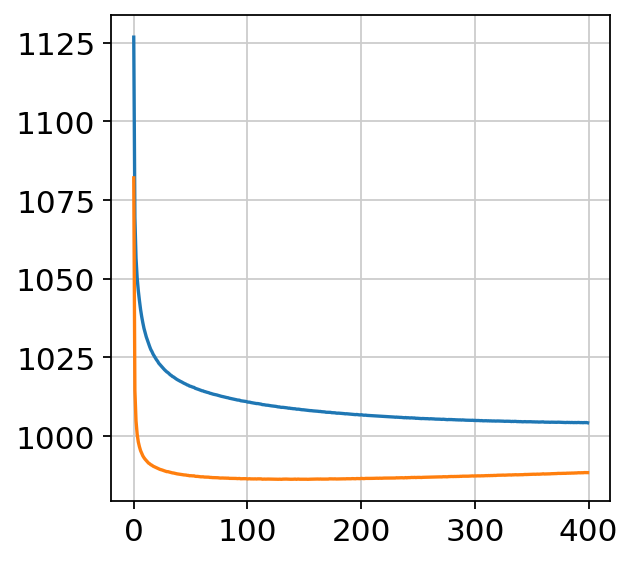

In [7]:
plt.plot(model.history["elbo_train"])
plt.plot(model.history["reconstruction_loss_train"])

# 3. Visualizations 

#### Latent space

In [8]:
# Regular scVI
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

latent.shape

(329762, 10)

### 2D Embedding plots

UMAP on PCA (Without scVI - no batch correction)

In [12]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


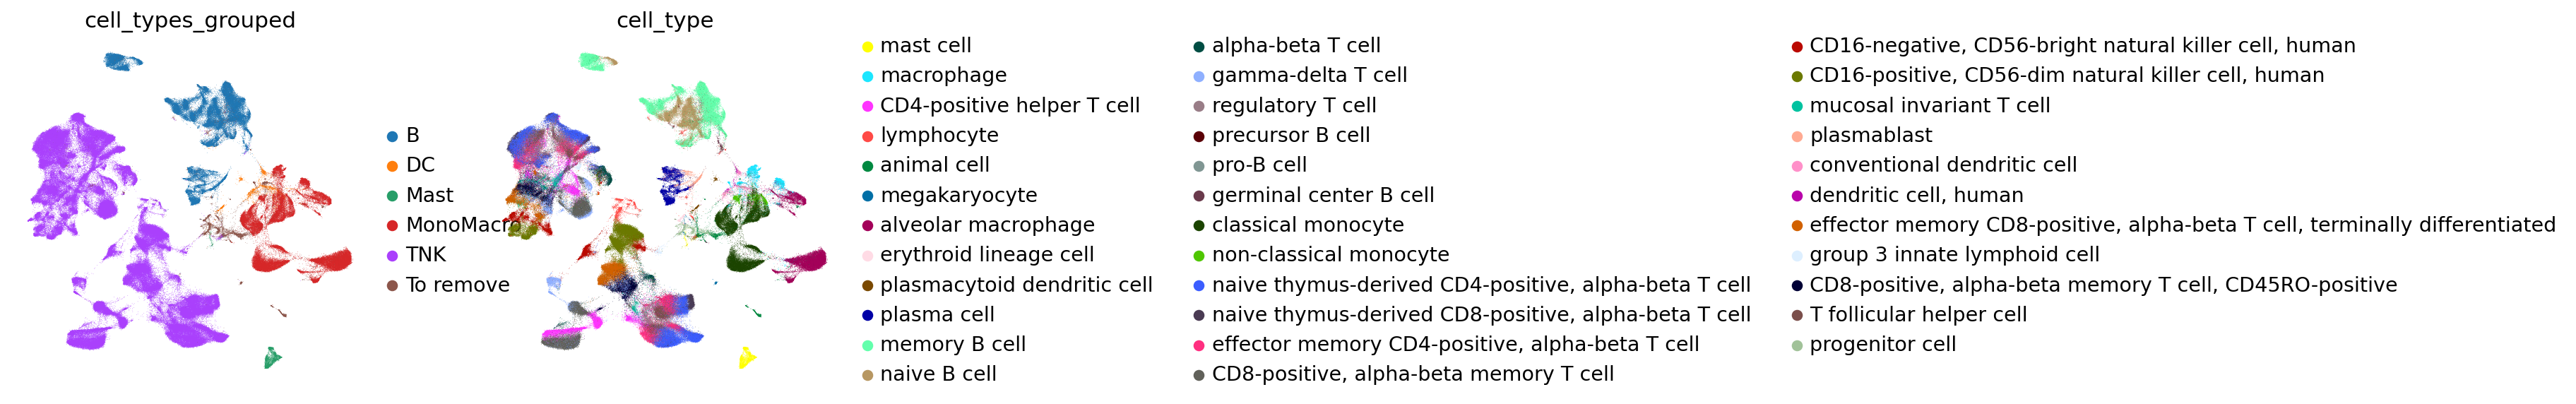

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


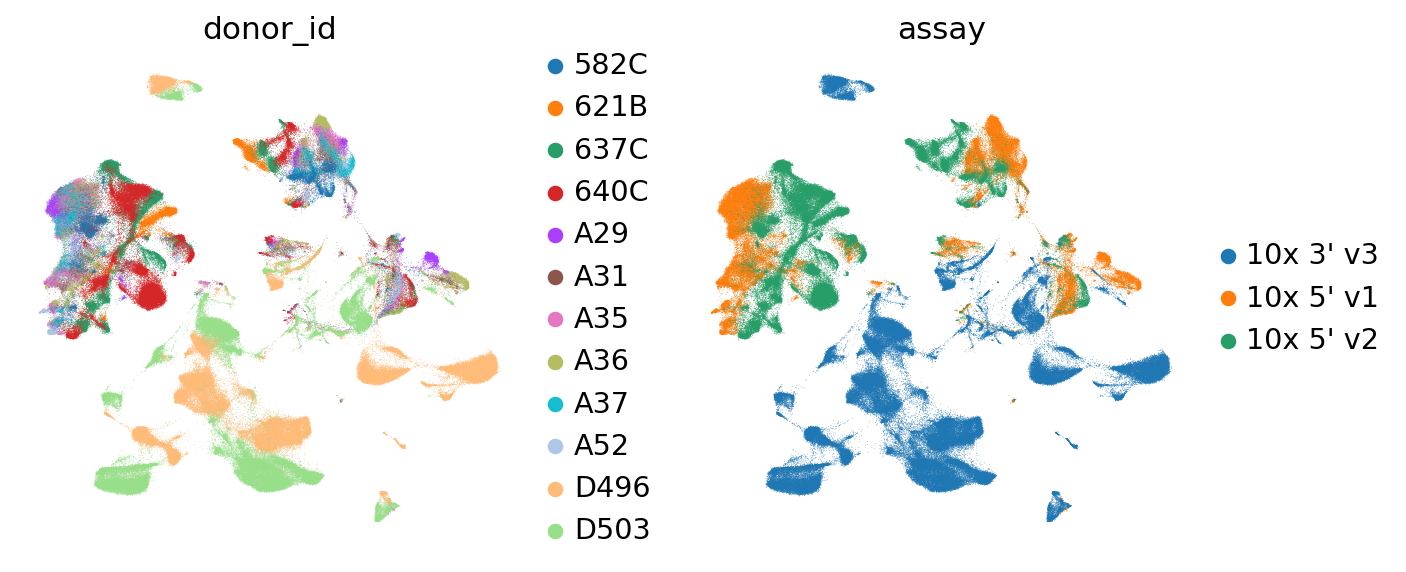

In [13]:
sc.pl.umap(
    adata,
    color=["cell_types_grouped", "cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor_id", "assay"],
    ncols=2,
    frameon=False,
)

UMAP on scVI latent spae

In [9]:
# run PCA then generate UMAP plots
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


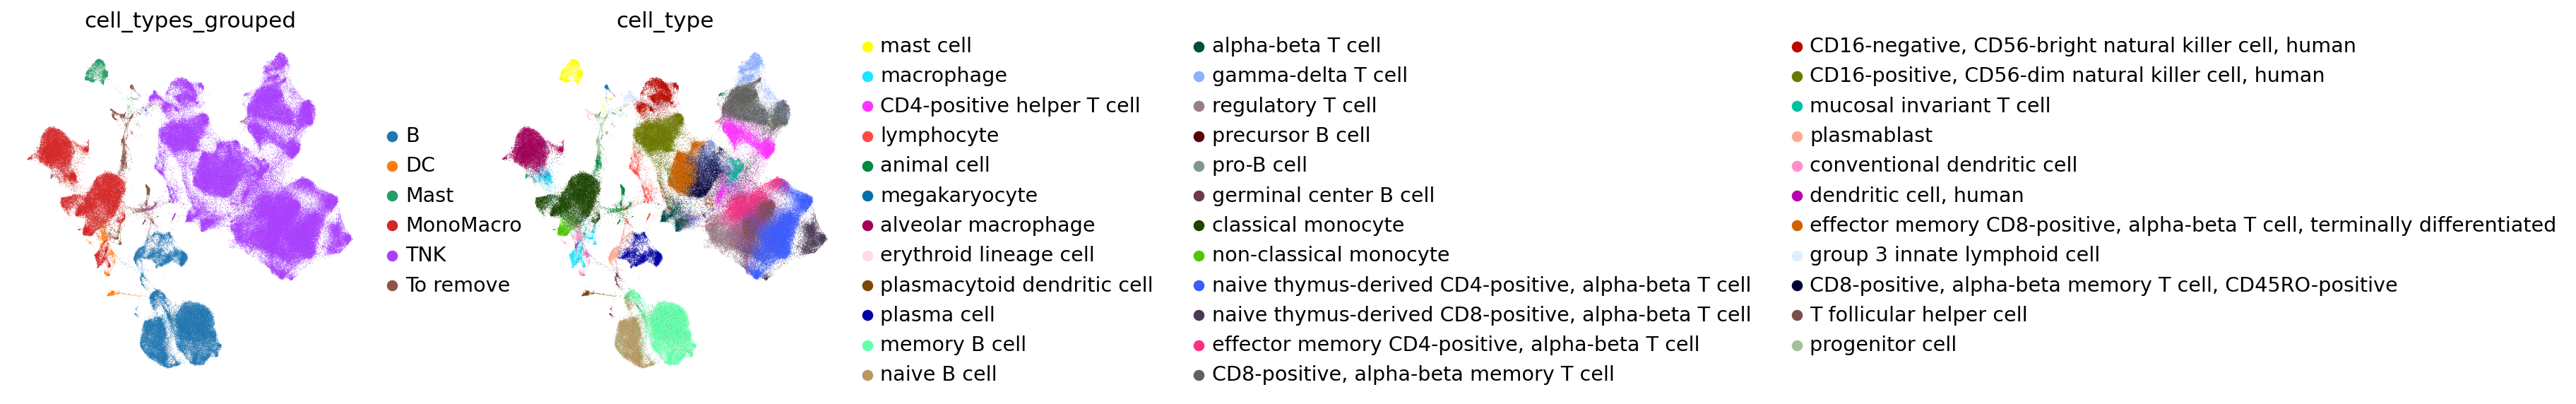

/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


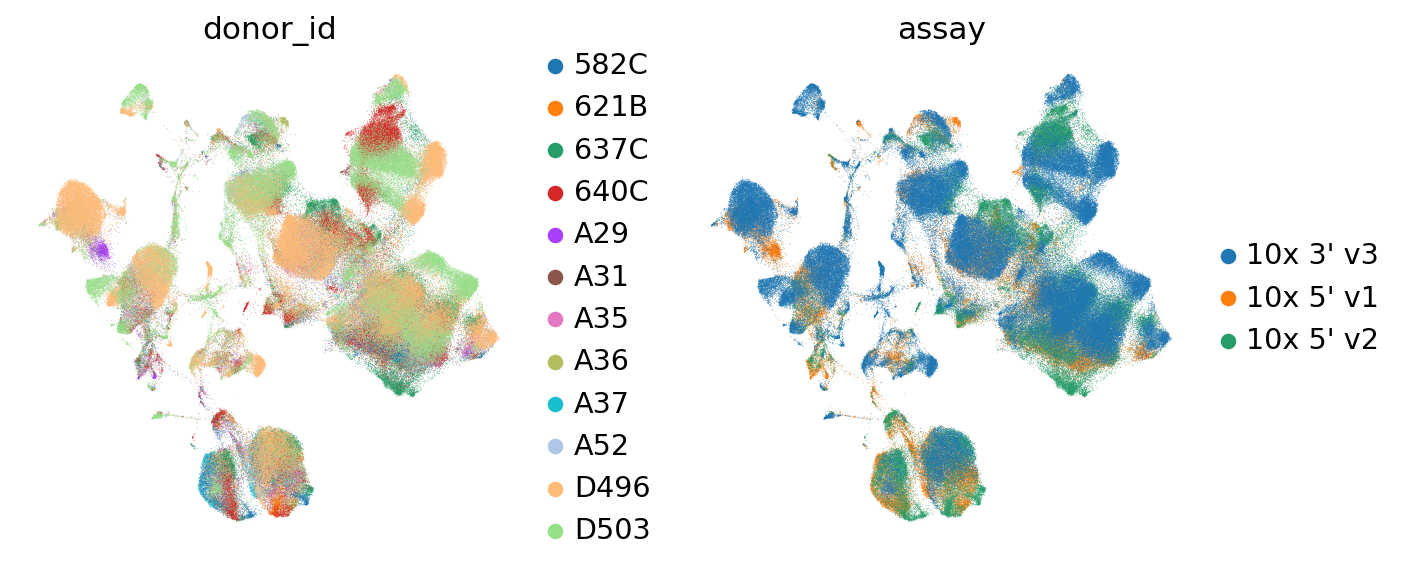

In [11]:
sc.pl.umap(
    adata,
    color=["cell_types_grouped", "cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor_id", "assay"],
    ncols=2,
    frameon=False,
)

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

We will use it to compute the **mean gene expression vector for each cell type present in the dataset** .

# 4. Building a signature matrix

### Denoised signature matrix (skip)

In [23]:
# Denoised signature matrix computation

# df_signature_denoised = pd.DataFrame()

# for cell_type in adata.obs["cell_types_grouped"].unique():
#     indices = adata[adata.obs.cell_types_grouped == cell_type].obs.index
#     integer_indices = adata.obs.index.get_indexer(indices)
#     # latent_subset = model.get_latent_representation(adata_subset)
#     denoised = model.get_normalized_expression(indices=integer_indices,
#                                                library_size=1e4)
#     df = denoised.mean(axis=0).to_frame()
#     df.columns = [cell_type]
#     df_signature_denoised = pd.concat([df_signature_denoised, df], axis=1)


# df_signature_denoised.drop(["To remove"], axis=1, inplace=True)

# keep_genes = list(set(signature.index) & set(df_signature_denoised.index))

# signature = signature.loc[keep_genes]
# df_signature_denoised = df_signature_denoised.loc[keep_genes]

# df_signature_denoised.to_csv("/home/owkin/project/Almudena/Output/Crosstiss_Immune/signature_cti_csv_5000.csv")

###### Vanilla signature matrix
# X_norm = sc.pp.normalize_total(adata,
#                                target_sum=1e4,
#                                layer="counts",
#                                inplace=False)['X']

# df_signature = pd.DataFrame()

# for cell_type in adata.obs["cell_type"].unique():
#     indices = adata[adata.obs.cell_type == cell_type].obs.index
#     integer_indices = adata.obs.index.get_indexer(indices)
#     df = pd.DataFrame(X_norm[integer_indices, :].mean(axis=0).T,
#              index=adata.var_names,
#              columns=[cell_type])
#     df_signature = pd.concat([df_signature, df], axis=1) 

Correlation between signature matrices

In [24]:
# import seaborn as sns 
# from scipy.stats import spearmanr, pearsonr
# import numpy as np

# cell_types = list(signature.columns)

# n_cols = 5

# fig, ax = plt.subplots(1, n_cols, figsize=(25, 5))

# for i in range(n_cols):
#     cell_type = cell_types[i]
#     x_sig = signature[cell_type].values
#     x_denoised = df_signature_denoised[cell_type].values
#     # keep_genes = pd.Index(list(set(marker_genes[cell_type]) & set(adata.var_names)))
#     # x_raw = df_signature.loc[keep_genes][cell_type].values
#     # x_denoised = df_signature_denoised.loc[keep_genes][cell_type].values
#     corr = spearmanr(x_sig, x_denoised)[0]
    
#     sns.scatterplot(x=x_sig,
#                     y=x_denoised,
#                     ax=ax[i]
#                     )
#     ax[i].set_xlabel(f"Denoised average ({cell_type})")
#     ax[i].set_ylabel(f"Signature average ({cell_type})")
#     ax[i].set_title(f"Correlation {np.around(corr,3)}")

### Denoised dataset

In [15]:
denoised_full = model.get_normalized_expression(
                                            library_size=1e4)

In [17]:
denoised_full.head()

gene_ids,ENSG00000187634,ENSG00000188290,ENSG00000187608,ENSG00000186891,ENSG00000186827,ENSG00000169962,ENSG00000179403,ENSG00000197785,ENSG00000224387,ENSG00000197921,...,ENSG00000198938,ENSG00000212907,ENSG00000198786,ENSG00000198695,ENSG00000276345,ENSG00000277856,ENSG00000275063,ENSG00000278782,ENSG00000277761,ENSG00000277836
Pan_T7935490_AAACCTGCAAATTGCC,0.010085,12.366870,7.226958,4.540140,1.722961,0.007128,0.012136,0.695736,0.002033,0.003838,...,229.519882,147.745026,56.710228,10.329220,0.110581,0.056487,0.044293,0.000033,0.001838,0.000568
Pan_T7935490_AAACGGGCATCTGGTA,0.010280,6.083390,6.545833,2.136263,0.114777,0.029685,0.016578,0.502464,0.003798,0.005032,...,235.236603,152.572540,53.002277,6.771439,0.054687,0.184247,0.236460,0.000752,0.008668,0.018603
Pan_T7935490_AAACGGGTCTTGCATT,0.004469,5.768851,3.937729,1.055308,0.052360,0.009099,0.010750,0.612423,0.001990,0.001787,...,375.120667,226.789413,81.329247,11.803660,0.074463,0.010554,0.018040,0.000111,0.000344,0.000110
Pan_T7935490_AAAGCAATCATCGCTC,0.006237,4.524779,4.965109,1.475137,0.125768,0.008453,0.009816,0.375015,0.002869,0.002989,...,348.499329,203.892563,78.891266,12.629306,0.059399,0.069451,0.093586,0.000059,0.001015,0.001478
Pan_T7935490_AAAGTAGCAGTCACTA,0.028000,17.578081,6.897396,9.233733,0.104765,0.039876,0.016698,0.584747,0.004495,0.011499,...,353.603485,272.238525,99.647362,20.022848,0.050534,0.037411,0.020372,0.000275,0.001220,0.002261


In [21]:
denoised_full.shape

(329762, 5000)

Save denoised dataset

In [22]:
denoised_full.to_csv("/home/owkin/project/Almudena/Output/Crosstiss_Immune/denoised_cti_5000.csv")

# 5. Latent space linearity sanity checks

In [28]:
adata.obs["cell_types_grouped"].value_counts(normalize=True)

cell_types_grouped
TNK          0.656871
B            0.160079
MonoMacro    0.139021
To remove    0.026534
Mast         0.009980
DC           0.007515
Name: proportion, dtype: float64

In [30]:
import random
from scipy.stats import pearsonr
import numpy as np

N = 10

# Define the number of cells you want to sample

batch_size = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192] 

corrs = []
pvals = []

for n in batch_size:
    for i in range(N):
        current_corrs = []
        current_pvals = []
        # Calculate the number of cells to sample from each cell type proportionally
        sampled_cells_per_type = adata.obs['cell_types_grouped'].value_counts(normalize=True) * n
        sampled_cells_per_type = sampled_cells_per_type.astype(int)

        # Perform stratified sampling for each cell type
        sampled_cells = []
        for cell_type, num_cells in sampled_cells_per_type.items():
            seed = random.seed()
            sampled_cells.extend(adata.obs[adata.obs['cell_types_grouped'] == cell_type].sample(n=num_cells,
                                                                                    random_state=seed).index)

        # print(sampled_cells)
        # Select the sampled cells from the DataFrame
        adata_sampled = adata[sampled_cells]

        # embeddings of single-cells
        # latent_sampled = model.get_latent_representation(adata_sampled)
        latent_sampled = model.module.z_encoder(torch.from_numpy(adata.layers["counts"].toarray()).to("cuda:0"))[1]
        latent_sampled = latent_sampled.detach().cpu().numpy()
        mean_sampled_z = latent_sampled.mean(axis=0)

        # pseudo-bulk embedding
        pseudobulk_x = adata_sampled.layers["counts"].mean(axis=0) #.astype(int).astype(numpy.float32)
        pseudobulk_z = model.module.z_encoder(torch.from_numpy(pseudobulk_x).to("cuda:0"))[1]
        pseudobulk_z = pseudobulk_z.detach().cpu().numpy().flatten()
        
        # Compute correlation
        pearson_corr = pearsonr(mean_sampled_z, pseudobulk_z)
        #print(pearson_corr[0], pearson_corr[1])
        current_corrs.append(pearson_corr[0])
        current_pvals.append(pearson_corr[1])
    corrs.append(np.mean(current_corrs))
    
        

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 4 in adata.obs['donor_id'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/owkin/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 4 in adata.obs['donor_id'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(
/home/owkin/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 1 in adata.obs['donor_id'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                         

Text(0.5, 1.0, 'Sanity check 0: correlation between sum(encodings)~=encoder(pseudo-bulk)')

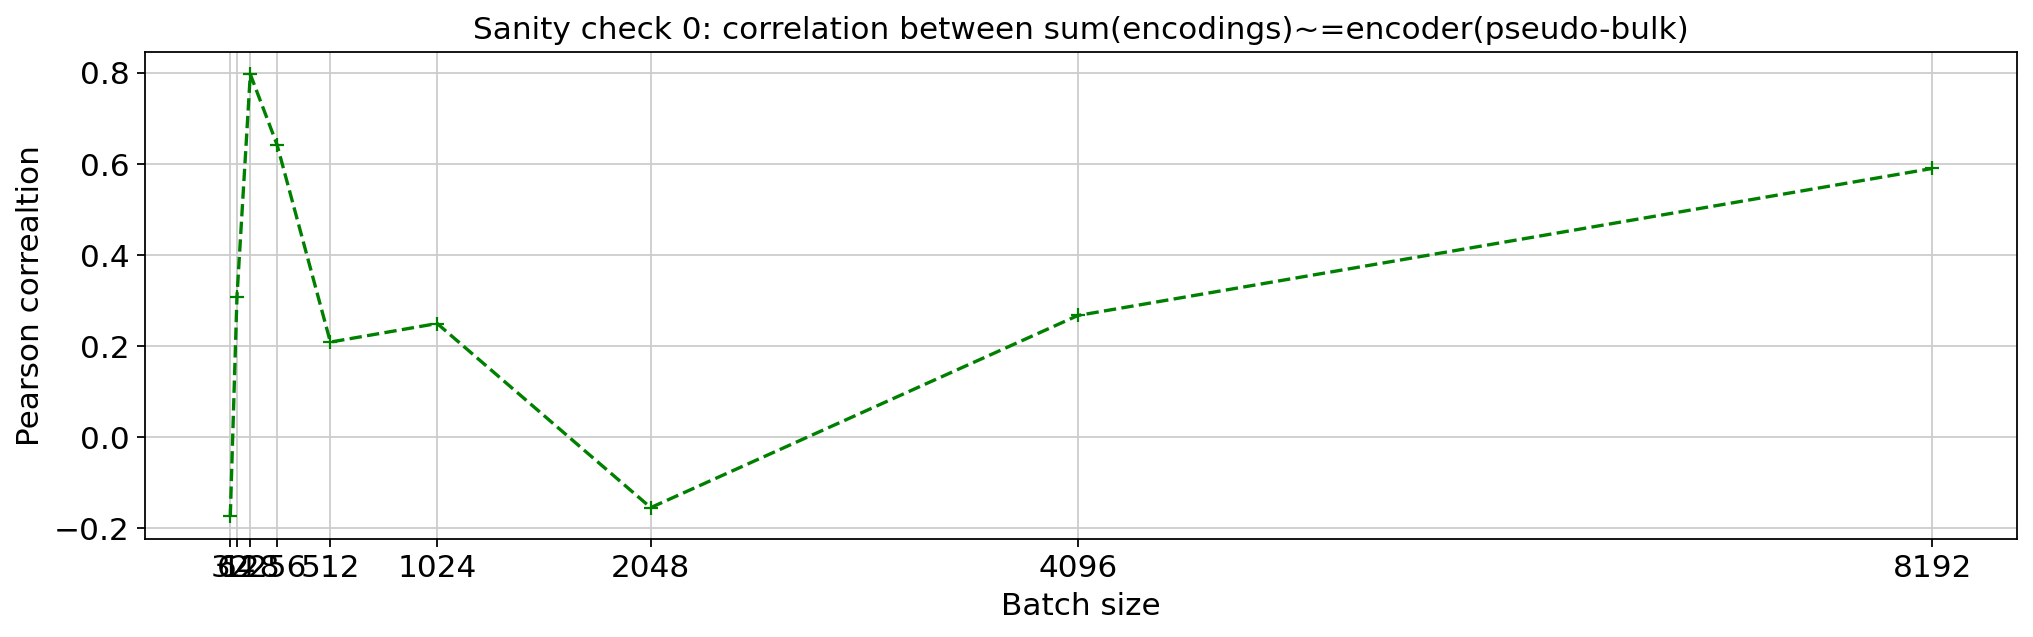

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

plt.plot(batch_size, corrs, color="green", linestyle="--", marker="+")
plt.xlabel("Batch size")
plt.ylabel("Pearson correaltion")
plt.xticks(batch_size)
plt.title("Sanity check 0: correlation between sum(encodings)~=encoder(pseudo-bulk)")

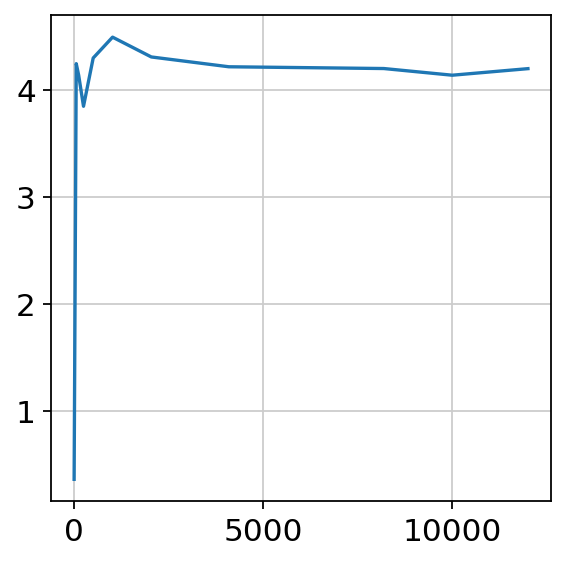

In [262]:
plt.plot(batch_size, -1 * numpy.log(p_values))